In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [97]:
column_names = ['id', 'type', 'lat', 'lon', 'amenity_name', 'shop', 'public_transport','highway']
initial_df = pd.read_csv("pois_all_info", sep='\t', header = 0, skiprows = 1, names = column_names, index_col = False)

df_ids = pd.read_csv("ny_municipality_pois_id.csv", header=None, names=["ID"])
ids = df_ids["ID"]

mask = [e in ids.values for e in initial_df["id"]]
df = initial_df[mask]

c:\users\fratt\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [98]:
df.dtypes

id                    int64
type                 object
lat                 float64
lon                 float64
amenity_name         object
shop                 object
public_transport     object
highway              object
dtype: object

In [99]:
for column in df.columns:
    missing_values = sum(df[column].isnull())
    print(f"{column} has {missing_values} missing_values")

id has 0 missing_values
type has 0 missing_values
lat has 0 missing_values
lon has 0 missing_values
amenity_name has 28823 missing_values
shop has 22971 missing_values
public_transport has 44803 missing_values
highway has 45146 missing_values


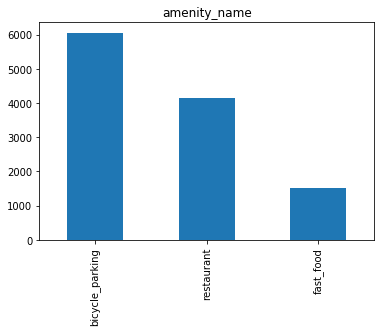

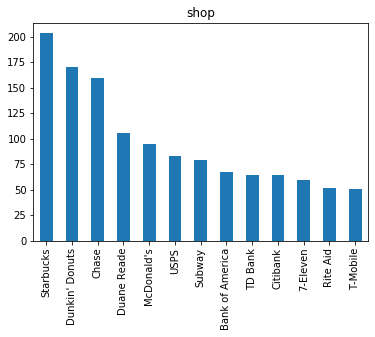

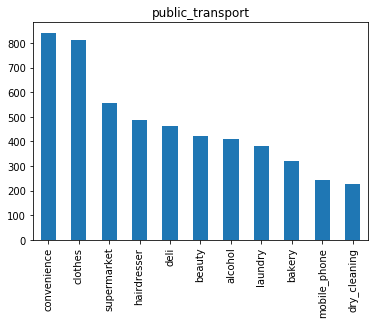

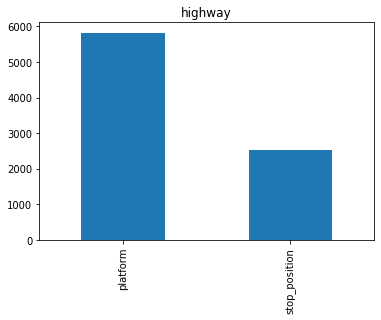

In [100]:
categories = ["amenity_name", "shop", "public_transport", "highway"]
for cat in categories:
    cat_series = df[cat]
    cat_series = cat_series[cat_series.notna()]
    plt.subplots()
    plt.title(cat)
    vc = cat_series.value_counts()
    vc = vc[vc > max(vc)*0.25]
    vc.plot(kind='bar')

In [147]:
def plot_category_pois(df, cat, cell_id=-1):
    
    
    cat_mask = df[cat].notna()
    cat_df = df[cat_mask]
    BBox = ((cat_df.lon.min(),   cat_df.lon.max(), cat_df.lat.min(), cat_df.lat.max()))
    
    if(cell_id >= 0):
        cat_df = cat_df[cat_df['cell_id'] == cell_id]
    
    img = mpimg.imread('New_York_City_Map.png')

    fig, ax = plt.subplots(figsize=(16,16))
    
    if(len(cat_df)> 0):
        cat_df, _ = filter_nonfrequent_types(cat_df, cat)
    
#     colors = pd.factorize(cat_df[cat])[0]
#     cat_df['color'] = colors
#     cat_df[['lat','lon','color',cat]].plot(ax = ax, x ='lon', y = 'lat', kind = 'scatter', s = 1.8, c = 'color', colormap='viridis')

    sns.scatterplot(ax = ax, x = 'lon', y = 'lat', hue=cat, data = cat_df)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

def filter_nonfrequent_types(cat_df, cat):
    vc = cat_df[cat].value_counts()
    vc = vc[vc > max(vc)*0.25]
    different_types = vc.index
    mask = [(c in different_types) for c in cat_df[cat]]
    return cat_df[mask], different_types

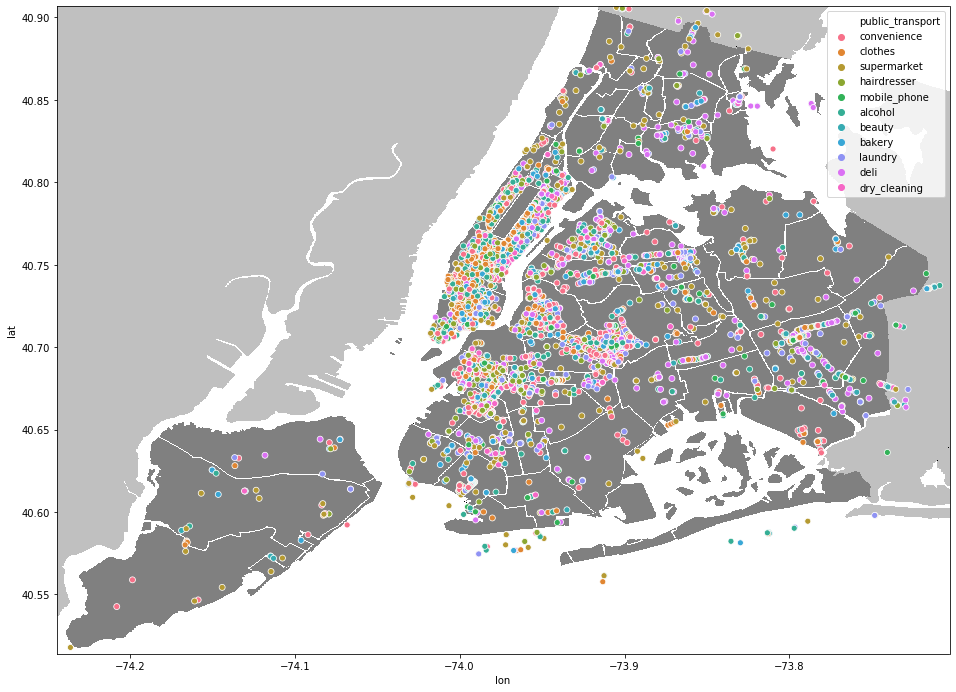

In [148]:
plot_category_pois(df, "public_transport")

In [110]:
# dividing the map in 0.05lonx0.05lat cells --> cell starting from 0 from the left-bottom
def split_geo_cell(df):
    width = 0.05
    n_lon = (df.lon.max()- df.lon.min())//width
    df['cell_id'] = ((df['lon'] - df.lon.min())//width) + n_lon*((df['lat'] - df.lat.min())//width)
    return

In [117]:
split_geo_cell(df)
df

c:\users\fratt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,type,lat,lon,amenity_name,shop,public_transport,highway,cell_id
0,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,61.0
1,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,75.0
2,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,84.0
3,42811266,node,40.704807,-73.772734,NaN,NaN,NaN,stop_position,53.0
4,42843048,node,40.745088,-73.864382,NaN,NaN,NaN,stop_position,51.0
...,...,...,...,...,...,...,...,...,...
76979,2553096114,node,40.736006,-73.713202,NaN,NaN,NaN,NaN,54.0
76980,2553096138,node,40.736020,-73.713063,NaN,NaN,NaN,NaN,54.0
76981,2553096143,node,40.736024,-73.713046,NaN,NaN,NaN,NaN,54.0
76982,2553096154,node,40.736030,-73.713089,NaN,NaN,NaN,NaN,54.0


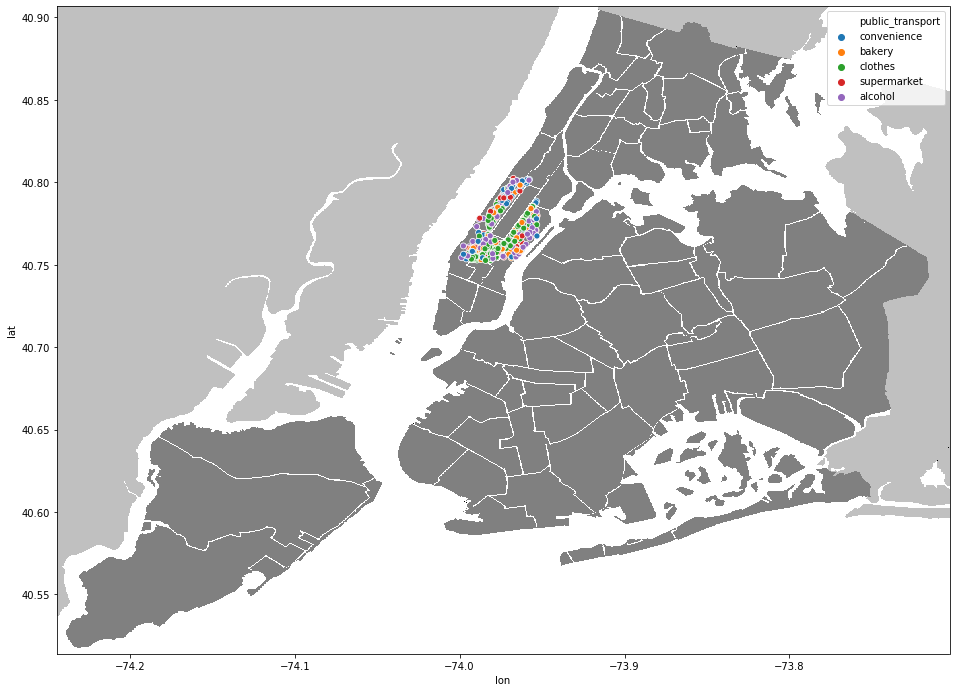

In [207]:
plot_category_pois(df, "public_transport", 60)

In [209]:
def correlation_matrix_category(cat):
    cat_df = df[['cell_id',cat]]
    cat_mask = cat_df[cat].notna()
    cat_df = cat_df[cat_mask]
    cat_df, _ = filter_nonfrequent_types(cat_df, cat)

    celltype_df = cat_df.groupby(['cell_id', cat])[cat].agg('count').to_frame('count').reset_index()
    celltype_df2 = celltype_df.pivot(index = 'cell_id', columns = cat, values = 'count').fillna(0)
    corr = celltype_df2.corr()
    plt.figure(figsize=(15,12))
    sns.heatmap(corr, annot=True, cmap='Reds')

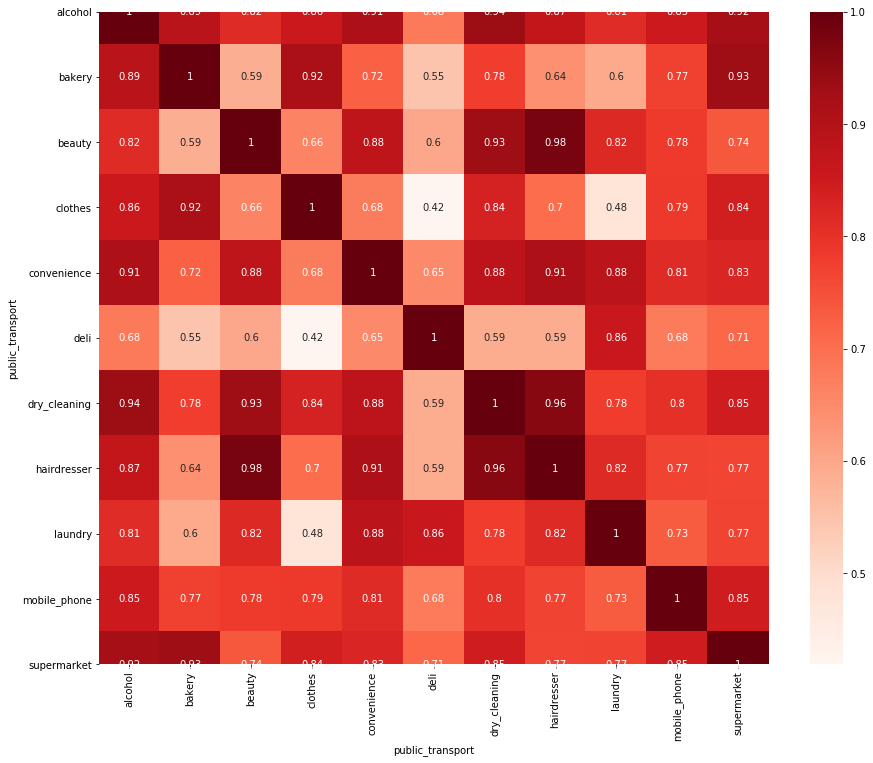

In [210]:
correlation_matrix_category('public_transport')

In [218]:
celltype_df2 = celltype_df.pivot(index = 'cell_id', columns = cat, values = 'count').fillna(0)
celltype_df2.head()

shop,7-Eleven,Bank of America,Chase,Citibank,Duane Reade,Dunkin' Donuts,McDonald's,Rite Aid,Starbucks,Subway,T-Mobile,TD Bank,USPS
cell_id,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0
13.0,1.0,1.0,2.0,0.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
14.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
celltype_df[celltype_df['cell_id'] == 12]

,cell_id,shop,count
5,12.0,Duane Reade,1
6,12.0,Dunkin' Donuts,2
7,12.0,McDonald's,1
8,12.0,Rite Aid,1
9,12.0,Starbucks,2
